In [4]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

import numpy as np
from os.path import join
import os

In [2]:
regions = ['borde_rural', 'borde_soacha', 'mixco_1_and_ebenezer', 'mixco_3']

In [3]:
region = 'mixco_1_and_ebenezer'
roof_dir = join('..', '..', 'data', region, 'roofs_train')
materials = {'healthy_metal':0, 'irregular_metal':1, 'concrete_cement':2, 'incomplete':3, 'other':4}

### Calculate features

This uses a pretrained network to compute features from the images, which are later classified.
First, load the model, from which we remove the top layer

In [4]:
model = ResNet50(weights='imagenet', include_top=False, pooling='max')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

Traverse all images in their corresponding folders which indicate the material and use `model.predict()` to get the features.

In [5]:
# Count the number of roofs
nof_roofs = 0;
for material in materials.keys():
    material_fp = join(roof_dir, material)
    nof_this = len([name for name in os.listdir(material_fp) if os.path.isfile(join(material_fp, name))])
    nof_roofs = nof_roofs + nof_this

labels = []
resnet50_feature_matrix = np.zeros((nof_roofs, 2048), dtype=float)

# Walk through all images
i = 0;
for material in materials.keys():
    material_fp = join(roof_dir, material)
    for root, dirs, files in os.walk(material_fp):
        for file in files:
            img_fp = join(material_fp, file)
            label = materials[material]
            labels.append(label)
            print(img_fp, "labeled as ", material, ":", label)
            
            # Pad if size is too small, preprocess
            img = image.load_img(img_fp, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)
            
            # Compute features 
            resnet50_feature = model.predict(img_data)
            resnet50_feature_np = np.array(resnet50_feature)
            resnet50_feature_matrix[i] = resnet50_feature_np.flatten()
            i = i + 1

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1c5eb8.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1c6ebc.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1c8a28.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1ca274.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1cb232.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1cb2be.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1ccba0.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1cce84.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1cd456.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a1cd7da.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a20430c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a204f28.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a205266.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a205e78.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a20601c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a206152.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a206ea4.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a207926.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a209960.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a20a784.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25a072.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25a5e0.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25b184.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25b260.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25c250.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25d416.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25d984.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25def2.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25ea82.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a25eeb0.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a290e38.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a291c02.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2924c2.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2937aa.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a293d7c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a293fb6.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a296068.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2962e8.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a296f2c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2986f6.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d5056.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d548e.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d58bc.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d5ace.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d65fa.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d6c9e.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d6e42.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d6ff0.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d79c8.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a2d8274.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a30dcb2.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a30f012.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a310886.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a310f16.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a31104c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a31255a.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a31269a.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3127d0.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a314076.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a314706.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a33d08e.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a33d156.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a33de08.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a33ed4e.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a33f370.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a33f604.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3401e4.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3449ba.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a345f54.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a346814.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a37ee08.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a380726.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3815d6.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a381d10.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3820f8.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a382846.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a38317e.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3844de.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a38477c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a38611c.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3b6538.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3b7e38.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3ba502.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3ba570.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3bc5e6.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3bd0cc.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3bd27a.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3bd450.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3be0bc.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3be6e8.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f015c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f01ca.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f0ae4.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f2484.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f315e.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f4496.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f4c48.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f5382.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f54c2.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a3f5cba.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42b2e8.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42b3ba.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42b48c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42b8c4.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42c350.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42cd0a.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42dc8c.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42e6a0.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42e7e0.tif labeled as  healthy_metal : 0
..\..\data\mixco_1_and_ebenezer\roofs_train\healthy_metal\7a42faa0.tif labeled as  healthy_

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1d616e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1d77b2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1d7d66.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1d7fc8.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1d88ec.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1d8a22.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1d8b58.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1d953a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1da584.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1fd494.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1fd99e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1fde08.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1fedc6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a1ff5fa.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a20039c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a200464.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a200ee6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a201224.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2216dc.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a221984.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a221ca4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2220b4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a222186.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a222ab4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a223216.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a223770.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a223f9a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2442f4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2446e6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2449e8.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2453ca.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a245c1c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a247008.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a24780a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a247b02.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a248246.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26b5c0.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26b91c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26beee.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26c1e6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26cef2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26d168.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26d316.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26e00e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a26eacc.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a28bfe6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a28cc3e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a28e084.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a28f89e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a290eb0.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2922d8.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a292530.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a292f12.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a292fee.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b5bac.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b5e2c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b5f08.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b6232.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b661a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b8258.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b8ab4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b8ba4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2b8c80.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d318e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d3260.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d35a8.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d3828.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d3fb2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d4660.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d47a0.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d480e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2d4a20.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f025c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f0d88.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f0ebe.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f14ae.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f1512.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f24bc.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f3c9a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f3d08.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a2f405a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a31190c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a311a42.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a311df8.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a312a46.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a312b18.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a313cca.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a313e0a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a31427e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a314558.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32d972.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32db7a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32dcb0.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32dde6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32e548.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32e87c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32ea20.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32f182.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a32f60a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a34d3da.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a34d5ec.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a34d8d0.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a34e104.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a34e37a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a34f6f8.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a34fa40.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3504fe.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3507e2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a36ede6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a36f57a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a36f6c4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3701e6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3707a4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a370952.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3712d0.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a371410.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a371cb2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38bc2a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38bcfc.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38c42c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38c6ac.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38d0b6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38d53e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38e7ea.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38f604.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a38ff28.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3aa5d0.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3aaf62.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3ab5ac.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3ac150.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3ac3c6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3aca10.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3acd80.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3ad2e4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3adae6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3c99c6.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3c9c50.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3c9fa2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3ca222.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3ca290.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3ca6b4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3caae2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3cb154.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3cb1c2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3e7ad4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3e7b38.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3e956e.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3e99ec.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3e9abe.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3ea158.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3eae8c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3eb242.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a3eb864.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a40776c.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a408752.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a408be4.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a409e36.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a40a61a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a40ae30.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a40b4f2.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a40c866.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a40cdc0.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a427878.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a427e4a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a428214.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a428e58.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a429718.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a429a10.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a429bc8.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a429d08.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a429d76.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_m

..\..\data\mixco_1_and_ebenezer\roofs_train\irregular_metal\7a44cb0a.tif labeled as  irregular_metal : 1
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a1c51c0.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a1c63e0.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a1c7416.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a1ca350.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a1ca562.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a1ca8d2.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a1cb34a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a1ccb32.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a20c9ee.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a20cb88.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a20e410.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a20f39c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a20f4fa.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a20f5a4.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a20ff36.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a21006c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a213302.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a255612.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a255b62.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2579ee.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a258d30.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a259a28.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a259fa0.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a25a144.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a25a2f2.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a25a860.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a29ae1a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a29b806.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a29bf9a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a29c42c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a29eae2.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a29efe2.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a29f8d4.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a29fec4.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2a179c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2e8f5c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2e924a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2e9326.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2ec44a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2ec58a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2ec79c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2ed3a4.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2ed4da.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a2eda98.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a31d0b8.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a31d39c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a31d40a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a31f16a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a31f3e0.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a31f796.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a32004c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a320db2.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a321ac8.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a35c2f4.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a35cba0.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a35cc0e.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a35d23a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a35ea22.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a36044e.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a360ae8.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a361402.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a36188a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3906a8.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a390f54.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a391238.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3914b8.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a392692.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a392dae.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a395572.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3964ae.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a396f26.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3c6eb0.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3c83e6.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3c8742.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3c96d8.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3ca074.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3caa7e.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3cb5fa.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3cb73a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a3cd1d4.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a407b9a.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a408964.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a409788.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a409c88.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a40a188.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a40a8cc.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a40b20e.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a40b420.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a40bb96.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a441a84.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a443618.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a4436e0.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a4437b2.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a44529c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a445774.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a44619c.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a446ef8.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_cement\7a448faa.tif labeled as  concrete_cement : 2
..\..\data\mixco_1_and_ebenezer\roofs_train\concrete_ce

..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a316a56.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a321f6e.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a3246ce.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a327784.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a328c06.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a334c18.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a338cd2.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a341cb0.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a349168.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a34c14c.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a34cc78.tif labeled as  other : 4
..\..\data\mixco_1_and_ebenezer\roofs_train\other\7a353050.tif la

In [6]:
import pickle
from os import makedirs
from os.path import exists

pickle_path = join('..', '..', 'pickles')
if not exists(pickle_path):
    makedirs(pickle_path)

with open(join(pickle_path, 'resnet50_feature_matrix_' + region + '.pkl' ), 'wb') as f:
    pickle.dump(resnet50_feature_matrix, f)
with open(join(pickle_path, 'labels_' + region + '.pkl' ), 'wb') as f:
    pickle.dump(np.asarray(labels), f)

### Visualize the features

Reduce the dimensionality to 2D using tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
%matplotlib inline

In [8]:
def plot_tSNE(features, labels=None, number_of_materials=5):
    if labels is None:
        labels = np.zeros((features.shape[0]))

    # Visualization_
    #pca_object = PCA(n_components=50)
    #pca_features = pca_object.fit_transform(features)
    tsne_features = TSNE(n_components=2).fit_transform(features)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, number_of_materials, number_of_materials + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    print(tsne_features.shape)
    
    # Plot D-Vectors
    plt.figure()
    scat = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, norm=norm)
    cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)

(3350, 2)


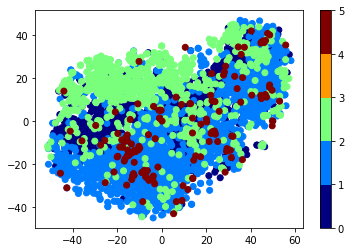

In [9]:
plot_tSNE(resnet50_feature_matrix, labels)

Calculating features on the test data:

In [8]:
import extracting_features
import pickle

pickle_path = join('..', '..', 'pickles')
for region in regions:
    resnet50_feature_matrix_test = extracting_features.extract_features_test(region)
    
    with open(join(pickle_path, 'resnet50_feature_matrix_' + region + '_test.pkl' ), 'wb') as f:
        pickle.dump(resnet50_feature_matrix_test, f)

In module:

In [5]:
import extracting_features

region = 'borde_rural'
resnet50_feature_matrix, labels = extracting_features.extract_features_training(region)

..\..\data\borde_rural\roofs_train\healthy_metal\7a1c4d74.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c5274.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c5daa.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c6296.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c701a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c7484.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c7f38.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c887a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c88e8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c964e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1c9842.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a1dbaec.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1dc1b8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1dc5b4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1dc618.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1dc67c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1dc7b2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1dc8e8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1dce24.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1dd978.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1df750.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1df9e4.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a1f60cc.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f613a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f627a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f66ee.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f6d06.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f7008.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f717a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f738c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f7530.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f7a12.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a1f7ada.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a20c980.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a20e2b2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a20e4ba.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a20eed8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a20f6f8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a20f838.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a20fbe4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a20ff9a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2100d0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a210616.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2108f0.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a22476a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a224b5c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a225a98.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a225b60.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a226524.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a226a10.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a227eec.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a228310.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a22903a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a22910c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a229850.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a24221a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a242300.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a242440.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a243494.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a243cbe.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a24404c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2447c2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a244830.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a24489e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a24490c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a244e52.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a25d04c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25d560.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25d772.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25e78a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25e8ca.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25eaf0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25ec94.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25ed02.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25f1f8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25f2ca.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a25f824.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a2752e6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a27593a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2759a8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a275e6c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a276ae2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a276e34.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a276ea2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a277186.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a27733e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a277a5a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a277ac8.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a28b9ba.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28c0fe.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28c266.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28c568.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28c856.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28c9aa.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28caf4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28cdf6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28d45e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28d54e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a28e4da.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a2a56bc.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a5ac2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a6378.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a6774.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a6832.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a68e6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a7a70.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a7b24.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a868c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a8768.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2a89e8.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a2c6984.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c715e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c7302.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c7b36.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c82c0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c8446.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c87fc.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c8c66.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c8e1e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c9116.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2c91e8.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a2da0c4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2da8c6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2dadda.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2db41a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2db640.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2dbb40.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2dc054.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2dc4f0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2dcdce.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2dce3c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2dd58a.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a2f0c3e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f1008.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f1364.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f16c0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f1724.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f1a76.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f1b48.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f2034.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f22b4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f2732.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a2f29a8.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a307416.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3078d0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a307aec.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a307b5a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a307f2e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a308d34.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3092b6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a309536.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a309e00.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a309f40.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a30a0ee.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a3215dc.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a321780.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a321924.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a321fdc.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a322bf8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a323b7a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a325006.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a325736.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a325c9a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3266ea.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a327072.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a339a38.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a339d1c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a339d80.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a33a5a0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a33abc2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a33af8c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a33b270.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a33b414.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a33be50.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a33bf9a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a33c2e2.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a34f626.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a34f68a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a34f96e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a34fb1c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a35042c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3508b4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3511ce.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a35137c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a351cf0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3520b0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a352452.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a36624a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a36631c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a366998.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a367078.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3672e4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a36767c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a367a50.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a367b22.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a368298.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3682fc.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3688a6.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a381ca2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a38240e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a38254e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3833f4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a383534.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a383cf0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3848c6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a385000.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a385582.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a385a50.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a385ab4.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a399870.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a399dd4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a399ea6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a39a3b0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a39a90a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a39b0da.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a39b49a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a39b56c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a39b97c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a39c2aa.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a39c5f2.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a3aed60.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3aedce.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3aef86.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3af3c8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3af6c0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3b0386.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3b0962.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3b09d0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3b0c50.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3b1704.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3b1c7c.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a3c475a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c4ba6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c5038.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c50a6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c52b8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c56e6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c6654.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c694c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c6b5e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c7126.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3c77d4.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a3da442.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3db298.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dbb9e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dbe78.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dc152.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dc3c8.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dc5d0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dc774.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dcbfc.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dcc6a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3dd430.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a3ef432.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3efa54.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3efb94.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3efc66.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3f03d2.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3f0b48.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3f10ac.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3f111a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3f11ec.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3f1674.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a3f17b4.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a408cc0.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a409364.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a409ae4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a409cf6.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a409f6c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a40a750.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a40a7be.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a40a930.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a40a99e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a40b132.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a40b484.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a424e98.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a42549c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a425a14.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a425d02.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a425e4c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a4263c4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a42657c.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a426720.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a426aea.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a426d7e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a4272ec.tif labeled as  health

..\..\data\borde_rural\roofs_train\healthy_metal\7a442a92.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a442de4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a442f24.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a443334.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a443afa.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a443c9e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a443f0a.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a443f6e.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a4441e4.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a444252.tif labeled as  healthy_metal : 0
..\..\data\borde_rural\roofs_train\healthy_metal\7a444a7c.tif labeled as  health

..\..\data\borde_rural\roofs_train\irregular_metal\7a1da32c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1db114.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1db632.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1dc082.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1dc6ea.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1dc884.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1dcd52.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1dd1c6.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1dd6da.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a1ddffe.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a200e82.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a201080.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2012f6.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a201440.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a20301a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a20322c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2034fc.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a203d6c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a203fd8.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a204bf4.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a221d76.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a222758.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a225110.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a225476.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a22557a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a225c32.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a225f0c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a226114.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a226dd0.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a22703c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a250d60.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2510c6.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a251274.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2512e2.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a251a80.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a251aee.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a251c38.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a252a8e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a252d0e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a253286.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a27a21e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27ba24.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27c0a0.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27c974.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27ceec.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27d72a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27d7fc.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27e774.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27ee40.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a27f2f0.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a2aa040.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2aabf8.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2aca8e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2acb92.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2ad876.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2ae3f2.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2b01a2.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2b03b4.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2b0468.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2b0a8a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a2d6d7a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d6f1e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d75ae.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d7a36.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d85bc.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d88a0.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d8904.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d8d50.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d9034.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2d9246.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a2f8614.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2f8678.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2f8894.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2f8b78.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2f9ef6.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2fa450.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2fa522.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2fa734.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2fabc6.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a2fac2a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a31972e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a319ecc.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a31a03e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a31b1aa.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a31b218.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a31b70e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a31bdb2.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a31c028.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a31c1d6.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a31c596.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a33b9be.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33bd7e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33c418.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33c8b4.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33c9f4.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33d430.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33e01a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33e7ea.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33ee84.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a33f1cc.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a35a620.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35ae68.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35af44.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35b21e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35b49e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35beda.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35ce84.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35cf56.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35e1e4.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a35e4c8.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a37eca0.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a37ed68.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a37ee76.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a380424.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a380640.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a380866.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3808d4.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a380bc2.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a381b58.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a381dec.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a3a2e0c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a3032.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a30f0.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a3802.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a4806.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a4a2c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a4a9a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a509e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a5332.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3a54cc.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a3c44da.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c484a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c4e8a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c4f66.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c5614.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c574a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c614a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c61b8.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c6226.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3c651e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a3e5838.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e6206.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e6788.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e699a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e6f4e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e708e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e7728.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e7930.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e7f16.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a3e92f8.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a40d75c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40e152.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40e2f6.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40eb3e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40ef62.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40f37c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40f6c4.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40f8d6.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40fdcc.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a40fe94.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\irregular_metal\7a42c2d8.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42c5d0.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42ceb8.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42d214.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42d570.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42de3a.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42df0c.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42e0c4.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42e772.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irregular_metal\7a42e98e.tif labeled as  irregular_metal : 1
..\..\data\borde_rural\roofs_train\irreg

..\..\data\borde_rural\roofs_train\concrete_cement\7a1d99fe.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1d9b34.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1e26e4.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1e2f04.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1e385a.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1e90c0.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1e9750.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1eb73a.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1ebf6e.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a1ec87e.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concr

..\..\data\borde_rural\roofs_train\concrete_cement\7a2dca72.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2e13e2.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2e1798.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2e19aa.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2e3156.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2e3e94.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2e7954.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2e9b6e.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2ec3dc.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a2f06bc.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concr

..\..\data\borde_rural\roofs_train\concrete_cement\7a3d80ca.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3da64a.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3daf50.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3dcf44.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3e0c0c.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3e2282.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3e3646.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3e3bfa.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3e62e2.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concrete_cement\7a3e9636.tif labeled as  concrete_cement : 2
..\..\data\borde_rural\roofs_train\concr

..\..\data\borde_rural\roofs_train\incomplete\7a250fea.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a252d7c.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a254b40.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a2568be.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a258754.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a258b82.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a25dc04.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a26936a.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a26d6e0.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a277262.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a2786ee.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a2798f0

..\..\data\borde_rural\roofs_train\incomplete\7a360084.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a361be6.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a362e1a.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a36869e.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a36a606.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a36b8e4.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a36bc7c.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a36ced8.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a36d220.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a36d572.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a370fec.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\incomplete\7a37174e

..\..\data\borde_rural\roofs_train\incomplete\7a4470b0.tif labeled as  incomplete : 3
..\..\data\borde_rural\roofs_train\other\7a1dc41a.tif labeled as  other : 4
..\..\data\borde_rural\roofs_train\other\7a1e6f46.tif labeled as  other : 4
..\..\data\borde_rural\roofs_train\other\7a255400.tif labeled as  other : 4
..\..\data\borde_rural\roofs_train\other\7a343d44.tif labeled as  other : 4
..\..\data\borde_rural\roofs_train\other\7a391026.tif labeled as  other : 4
..\..\data\borde_rural\roofs_train\other\7a3d7dfa.tif labeled as  other : 4
..\..\data\borde_rural\roofs_train\other\7a3dd502.tif labeled as  other : 4
..\..\data\borde_rural\roofs_train\other\7a3f2984.tif labeled as  other : 4


In [6]:
import pickle
from os import makedirs
from os.path import exists, join
import numpy as np

pickle_path = join('..', '..', 'pickles')
if not exists(pickle_path):
    makedirs(pickle_path)

with open(join(pickle_path, 'resnet50_feature_matrix_' + region + '.pkl' ), 'wb') as f:
    pickle.dump(resnet50_feature_matrix, f)
with open(join(pickle_path, 'labels_' + region + '.pkl' ), 'wb') as f:
    pickle.dump(np.asarray(labels), f)